VGG16のpretrainモデルをfine-tuningしてDogとCatの分類をする

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

In [2]:
# hyper parameters
batch_size = 32

### データ準備
Kaggleの[イヌとネコのコンペサイト](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)から画像 ``train.zip`` と ``test.zip`` をダウンロードする。kaggle-cliというコマンドラインツールを使うと、Kaggleにログインした上でコマンドでデータのダウンロードができるのでとても便利！

各種ディレクトリのパスを定義する。

In [3]:
import os
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "data", "dogscats")
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")


訓練画像は25000枚、テスト画像は15000枚。訓練データからランダムに選んだ2000枚をバリデーションデータとする。

In [4]:
# %cd $train_dir
# import os
# from glob import glob
# import numpy as np
# g = glob("*.jpg")
# shuf = np.random.permutation(g)
# for i in range(2000):
#     os.rename(shuf[i], os.path.join(valid_dir, shuf[i]))


PyTorchで読み込みやすいようにクラスごとにサブディレクトリを作成する。Kaggleのテストデータは正解ラベルがついていないため ``unknown`` というサブディレクトリにいれる.

In [5]:
# # train
# %cd $train_dir
# %mkdir cats dogs
# %mv cat.*.jpg cats/
# %mv dog.*.jpg dogs/

# # valid
# %cd $valid_dir
# %mkdir cats dogs
# %mv cat.*.jpg cats/
# %mv dog.*.jpg dogs/

# # test
# %cd $test_dir
# %mkdir unknown
# %mv *.jpg unknown

### VGG16のFine-tuning

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

(classifier) の (6) の出力が1000クラスになっているのでここをイヌとネコの2クラスにする。

[ここを](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor)参考に最後の層だけ学習するようにした

In [7]:
# 全層のパラメータを固定する
for param in vgg16.parameters():
    param.require_grad = False

# 最後の層の出力を2クラスにする。
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)

In [5]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
vgg16.to(device)

print(vgg16)

NameError: name 'vgg16' is not defined

### データのロード
まずデータ変換関数を定義する。訓練用とテスト用を分けたが同じ内容でOK。``train_preprocess`` の方に[データ拡張](http://aidiary.hatenablog.com/entry/20180217/1518833659)を入れるとさらに精度が上がるかも？

In [6]:
train_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

各ディレクトリから画像をロードするDataSetを作成

In [7]:
train_dataset = datasets.ImageFolder(train_dir, train_preprocess)
valid_dataset = datasets.ImageFolder(valid_dir, test_preprocess)
test_dataset = datasets.ImageFolder(test_dir, test_preprocess)

下のコードでクラスラベルを確認できる

In [8]:
classes = train_dataset.classes
print(train_dataset.classes)
print(valid_dataset.classes)
print(test_dataset.classes)

['cats', 'dogs']
['cats', 'dogs']
['unknown']


サブディレクトリの cats がラベル0で dogs がラベル1になっていることがわかる。おそらくアルファベット順にラベルが割り当てられるのだろう。unknownはラベル0だけどこれはテスト時にしか使わないので問題ない。

データをミニバッチ単位で取得するDataLoaderを定義。バッチサイズは128にし、訓練データだけシャッフルする。

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

1バッチだけデータを描画してみよう

torch.Size([32, 3, 224, 224]) torch.Size([32])


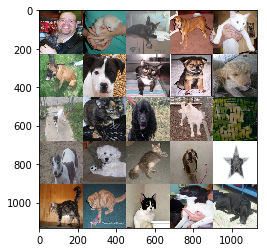

In [15]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(train_loader))
print(images.size(), classes.size())
grid = torchvision.utils.make_grid(images[:25], nrow=5)
imshow(grid)

### モデルの訓練

``optimizer``には、更新対象のパラメータだけ渡す必要があるので注意。``requires_grad = False`` で固定しているパラメータを含む``vgg16.parameters()``を指定するとエラーになる。

Fine-tuningなので学習率を小さめにしたSGDを使う。

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)

訓練とバリデーションの関数を定義

In [15]:
def train(model, criterion, optimizer, train_loader):
    model.train()  # set train mode
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
            
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss / len(train_loader)
    
    return train_loss


def valid(model, criterion, valid_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
    val_loss = running_loss / len(valid_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

出力の ``logs`` を予め作成しておく。**エポックガンガン回したあとに出力先ディレクトリがなくてエラーになる**と悲惨・・・あとで[TensorBoardX](https://github.com/lanpa/tensorboardX/tree/master/tensorboardX)を導入してTensorBoardでロギングするとこういうディレクトリ作成がいらなくなる。

Fine-tuningなので5エポックと少しだけ回した。

In [16]:
num_epochs = 5
log_dir = "./trained_models/transfer_learning_vgg16"

best_acc = 0
loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    loss = train(vgg16, criterion, optimizer, train_loader)
    val_loss, val_acc = valid(vgg16, criterion, valid_loader)
    
    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
          % (epoch, loss, val_loss, val_acc))
    
    if val_acc > best_acc:
        print('val_acc improved from %.5f to %.5f!' % (best_acc, val_acc))
        best_acc = val_acc
        model_file = 'epoch%03d-%.3f-%.3f.pth' % (epoch, val_loss, val_acc)
        torch.save(vgg16.state_dict(), os.path.join(log_dir, model_file))

    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

KeyboardInterrupt: 

### テストデータに対する評価

最後にテストデータで評価してみよう。Kaggleのテストデータはラベルがついていないので認識率を求められない。なのでいくつかの画像を描画して目視で確認してみた。

まずは学習済みモデルをロード。PyTorchは重みファイルだけ保存するのが推奨になっていたので、対応するモデル構造は予め用意する必要がある。モデルと重みを両方保存することもできるのかな？

- (参考) [Best way to save a trained model in PyTorch? - Stack Overflow](https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch)
- GPUで学習したチェックポイントをCPUでロード [On a cpu device, how to load checkpoint saved on gpu device](https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349)

In [10]:
weight_file = "./trained_models/transfer_learning_vgg16/epoch001-0.026-0.992.pth"

model = models.vgg16(pretrained=True)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)

model.load_state_dict(torch.load(weight_file, map_location=lambda storage, loc: storage))

テストデータのDataLoaderを作成して最初の128枚の画像をロードする

In [12]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images, _ = iter(test_loader).next()
print(images.size())

torch.Size([32, 3, 224, 224])


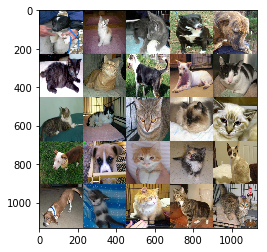

In [13]:
imshow(torchvision.utils.make_grid(images.data[:25], nrow=5))

OK。``test_loader``は ``shuffle=False`` なので順番は固定のはず。でも順番どおりでないな？と思ったら ``1.jpg, 10.jpg, 100.jpg, 1000.jpg`` のようにアルファベット順に並んでいた・・・

ネットワークに通して予測する

In [14]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

``predicted`` には0（ネコ）、1（イヌ）の予測ラベルが入っている。

In [15]:
print(predicted.numpy())

[1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1]


``numpy()`` してTensorからndarrayに戻したのは出力が上のようにコンパクトに表示されるからで深い意味はない。

この結果から1（イヌ）と予測された画像だけ取り出すには下のように書けばよい。

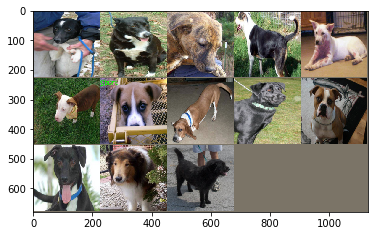

In [16]:
pred_dogs_images = images[predicted.nonzero().view(-1), :, :, :]
imshow(torchvision.utils.make_grid(pred_dogs_images.data[:25], nrow=5))

- ``predicted.nonzero()`` で0でない（つまり1）のインデックスが取得できる
- ただし、サイズが (62, 1) のように2D tensorで返ってくるので、``view(-1)`` で1Dtensorにしてからインデキシング

逆に0（ネコ）と予測された画像だけ取り出すには下のように書けばよい。

In [17]:
pred_cats_images = images[(predicted != 1).nonzero().view(-1), :, :, :]
imshow(torchvision.utils.make_grid(pred_cats_images.data[:25], nrow=5))

- predicted != 1 で0と1がひっくり返る
- (predicted != 1).nonzero() で0のインデックスが取得できる
- (参考) [Find indices with value (zeros) - PyTorch Forums](https://discuss.pytorch.org/t/find-indices-with-value-zeros/10151)

テストデータでもかなりの精度で予測できていることがわかる。

### おまけ  Kaggleに提出

In [11]:
import pandas as pd

SubmitするにはIDと予測結果が必要なのでIDを返すImageFolderクラスを作る

(参考) [Return image names/path when iterating through DataLoader](https://discuss.pytorch.org/t/return-image-names-path-when-iterating-through-dataloader/4338/4)

In [12]:
import os

class ImageFolderWithIds(datasets.ImageFolder):
    """
    ImageFolderクラスは普通Imageとlabelしか返さない。そこでIdも一緒に返すようにする
    """
    
    # __getitem__メソッドをオーバーライドする
    def __getitem__(self, index):
        # 普通のImageFolder.__getitem__の返すもの
        original_tuple = super(ImageFolderWithIds, self).__getitem__(index)
        # image path
        path = self.imgs[index][0]
        # id を取り出す
        image_ids = os.path.splitext(os.path.basename(path))[0]
        # idを組み合した新しいtupleを作る
        tuple_with_id = (original_tuple + (image_ids,))
        return tuple_with_id

In [13]:
test_dataset = ImageFolderWithIds(test_dir, test_preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# テスト
images, labels, ids = iter(test_loader).next()
imshow(torchvision.utils.make_grid(images.data, nrow=8))
print(labels)  # すべて"unknown"なので0
print(ids)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
('1', '10', '100', '1000', '10000', '10001', '10002', '10003', '10004', '10005', '10006', '10007', '10008', '10009', '1001', '10010', '10011', '10012', '10013', '10014', '10015', '10016', '10017', '10018', '10019', '1002', '10020', '10021', '10022', '10023', '10024', '10025')


In [17]:
model.to(device)
model.eval()
images = images.to(device)
outputs = model(images)
outputs.size()

torch.Size([32, 2])

In [18]:
preds = []

model.to(device)
model.eval()
for (images, labels, ids) in test_loader:  # 今回の場合labelsはすべて"unknown"
        images = images.to(device)
        outputs = model(images)
        
        # 出力を確率にする.
        outputs = nn.functional.softmax(outputs, dim=1)
        # cpu上で操作するので普通のメモリに乗せる + ndarrayに変換
        outputs = outputs.cpu().data.numpy()
        
        for img_id, pred in zip(ids, outputs):
            preds.append((img_id, pred[1]))  # 犬である確率を予測するのでインデックス1の数値を取る

In [21]:
len(preds)

12500

In [ ]:
# 予測結果を少し見てみる
preds[:5]

提出するのは犬である**確率**なので``torch.max``で分類する必要はない

In [26]:
# ID順でソート
sorted_preds = sorted(preds, key=lambda x: int(x[0]))

In [27]:
# submission.csvのdf
submission = pd.DataFrame(sorted_preds, columns=["id", "label"])

In [30]:
submission.to_csv("dogscats_submit.csv", index=False)